From the code for the following article [Sub-sampling for Efficient Non-Parametric Bandit Exploration](https://arxiv.org/abs/2010.14323)

In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

In [2]:
from MAB import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Parameters and aliases for all algorithms

In [3]:
# Enter the parameters of each algorithms
param = {'non_parametric_TS': {}}

mapping = {'B': BetaBernoulliMAB, 'G': GaussianMAB, 'LG': LogGaussianMAB, 'Exp': ExponentialMAB, 'TG': TruncGaussianMAB}
mapping_name = {'B': 'Bernoulli', 'G': 'Gaussian', 'LG': 'LogGaussian', 'Exp': 'Exponential', 'TG': 'Truncated Gaussian'}

### Bounded arms

In [4]:
bandit = 'B'  # 'B', 'G', 'LG', 'Exp', 'TG'
p = [0.7, 0.5]  # parameters for the arms distribution
T = 1000  # Horizon
N = 25  # Number of MC runs
step = 25  # If results are saved trajectories are stored for all rounds such that t%step=0

In [5]:
model = mapping[bandit](p)

r_1, _ = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': 1.0}, step)
r_2, _ = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': None}, step)

all_r = [r_1, r_2]
all_r.append(model.Cp * np.log(1 + np.arange(T)))

res = pd.DataFrame(all_r).T
res.columns = ['NP-TS', 'NP-TS (unknown bound)', 'lower bound']
res['lower bound'].iloc[0] = 0

Computing 25 simulations:   0%|          | 0/25 [00:00<?, ?it/s]/home/sauxpa/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Computing 25 simulations: 100%|██████████| 25/25 [00:03<00:00,  7.04it/s]


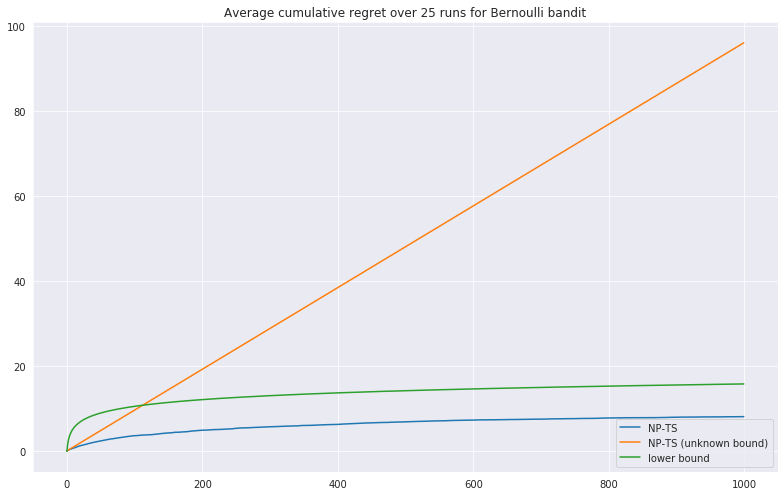

In [6]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)

    res.plot(ax=ax)
    
    ax.legend(loc='lower right')
    ax.set_title('Average cumulative regret over {} runs for {:s} bandit'.format(N, mapping_name[bandit]))

    plt.tight_layout()
    plt.show()

### Unbounded arms (Gaussian)

In [7]:
bandit = 'G'  # 'B', 'G', 'LG', 'Exp', 'TG'
p = [[0.1, 0.3], [0.2, 0.25]]  # parameters for the arms distribution
T = 1000  # Horizon
N = 25  # Number of MC runs
step = 25  # If results are saved trajectories are stored for all rounds such that t%step=0

In [8]:
model = mapping[bandit](p)

r_1, _ = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': 1.0}, step)
r_2, _ = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': None}, step)

all_r = [r_1, r_2]
all_r.append(model.Cp * np.log(1 + np.arange(T)))

res = pd.DataFrame(all_r).T
res.columns = ['NP-TS', 'NP-TS (unknown bound)', 'lower bound']
res['lower bound'].iloc[0] = 0

Computing 25 simulations: 100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


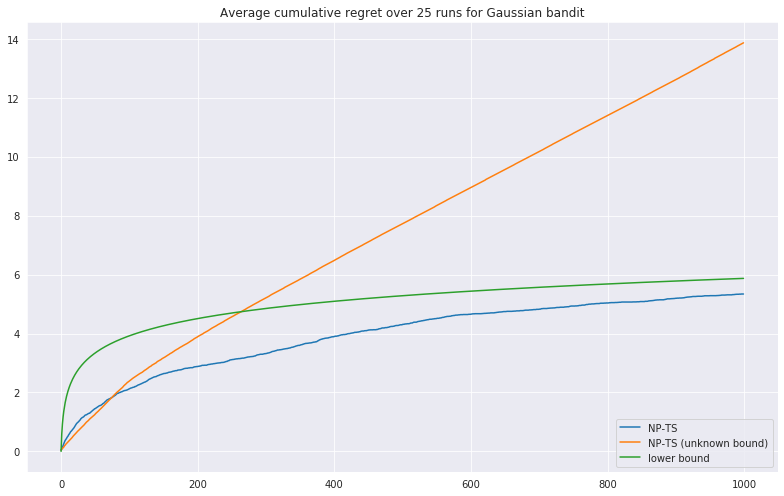

In [9]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)

    res.plot(ax=ax)
    
    ax.legend(loc='lower right')
    ax.set_title('Average cumulative regret over {} runs for {:s} bandit'.format(N, mapping_name[bandit]))

    plt.tight_layout()
    plt.show()

### Unbounded arms (Exponential)

In [10]:
bandit = 'Exp'  # 'B', 'G', 'LG', 'Exp', 'TG'
p = [1.0, 0.8]  # parameters for the arms distribution
T = 1000  # Horizon
N = 25  # Number of MC runs
step = 25  # If results are saved trajectories are stored for all rounds such that t%step=0

In [11]:
model = mapping[bandit](p)

r_1, _ = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': 1.0}, step)
r_2, _ = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': None}, step)

all_r = [r_1, r_2]
all_r.append(model.Cp * np.log(1 + np.arange(T)))

res = pd.DataFrame(all_r).T
res.columns = ['NP-TS', 'NP-TS (unknown bound)', 'lower bound']
res['lower bound'].iloc[0] = 0

Computing 25 simulations: 100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


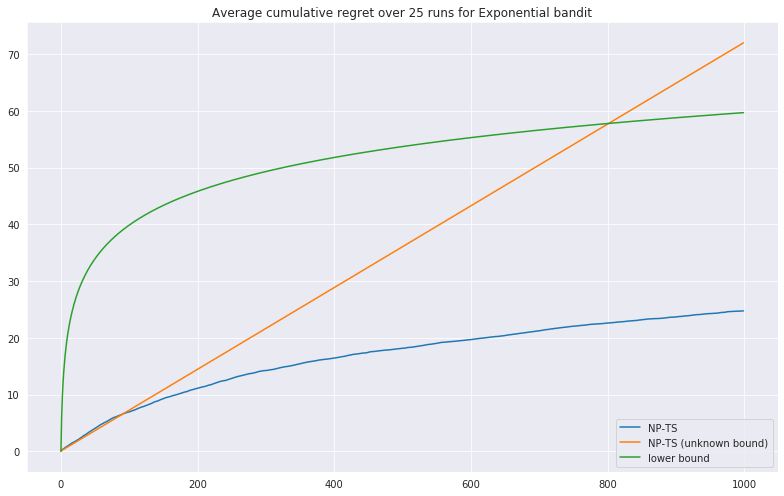

In [12]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)

    res.plot(ax=ax)
    
    ax.legend(loc='lower right')
    ax.set_title('Average cumulative regret over {} runs for {:s} bandit'.format(N, mapping_name[bandit]))

    plt.tight_layout()
    plt.show()

### Unbounded arms (Lognormal --> heavy tail)

In [16]:
bandit = 'LG'  # 'B', 'G', 'LG', 'Exp', 'TG'
p = [[0.2, 0.3], [0.2, 0.25]]  # parameters for the arms distribution
T = 1000  # Horizon
N = 25  # Number of MC runs
step = 25  # If results are saved trajectories are stored for all rounds such that t%step=0

In [17]:
model = mapping[bandit](p)

r_1, _ = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': 1.0}, step)
r_2, _ = model.MC_regret('non_parametric_TS', N, T, {'upper_bound': None}, step)

all_r = [r_1, r_2]
all_r.append(model.Cp * np.log(1 + np.arange(T)))

res = pd.DataFrame(all_r).T
res.columns = ['NP-TS', 'NP-TS (unknown bound)', 'lower bound']
res['lower bound'].iloc[0] = 0

Computing 25 simulations: 100%|██████████| 25/25 [00:03<00:00,  6.62it/s]


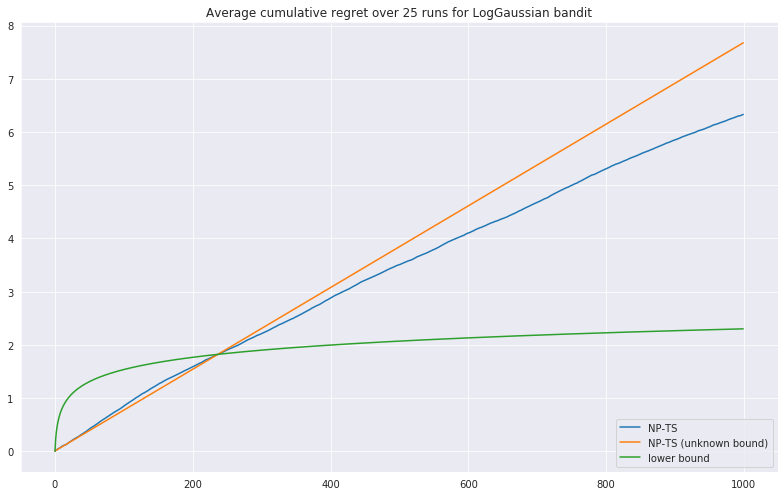

In [18]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)

    res.plot(ax=ax)
    
    ax.legend(loc='lower right')
    ax.set_title('Average cumulative regret over {} runs for {:s} bandit'.format(N, mapping_name[bandit]))

    plt.tight_layout()
    plt.show()